# Sander van de Kamp
#### 500734351 
#### 04/06/2021
# Reinforcement Q-learning Taxi

Heb alle text gegenereerde output weggehaald en vervangen met afbeeldingen ervan (knip en plak van de output)

Het doel van de Q-learning taxi is om een model te maken dat op elke mogelijke scenario de best mogelijke oplossing weet, waardoor de taxi de snelst mogelijke manier weet om 1 passagier op te pakken en deze naar de dichts bijzijnde afzet plaats weet te brengen. Om dit te doen zijn er verschillende manieren om het op te lossen, waarbij er verschillende Q-learning methodes en berekeningen zijn waaruit gekozen kan worden, alleen om het op te lossen heb ik deze methode genomen die per staat de beste actie gaat onthouden. Dit zal geleerd worden door voor elke mogelijke staat willekeurige acties te nemen en per actie te bepalen of deze goed of slecht was, hierdoor zal het model het model langzaam voor elke staat leren wat de best mogelijke actie is.

In deze opdracht zal er gebruik gemaakt worden van de Taxi omgeving van gym, wat een veld kan genereren met willekeurige onderbrekingen erin met 2 passagiers en 2 afzet locaties.

---

**Taxi doeleindes en richtlijnen**

Op het veld hieronder zijn de R en Y de mogelijke plekken waar de passagiers afgezet kunnen worden en de G en B zijn de mogelijke plekken waar een passagier opgepakt kan worden. Als de taxi begint bovenin het veld zal het dus eerst bij G een passagier op pakken en daarna naar R brengen, terwijl als de taxi onderin begint dat het eerst naar B zal gaan en dan kan het de passagier brengen naar Y of R.

Ook kan de taxi niet rijden tussen twee velden waar een dichte strook tussen zit, hierdoor is er voor elke staat van het veld een andere optimale route die gevoden kan worden 

Het doel van de taxi is om waar het ook begint één enkele passagier op te pakken en deze af te zetten, waarbij het zo min mogelijke stappen nodig heeft om er uit te komen.

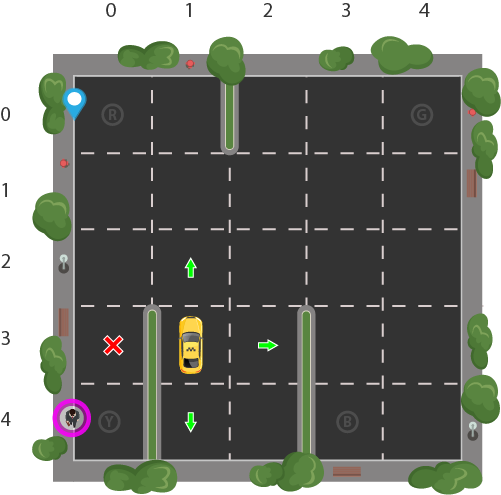

In [4]:
import gym
from IPython.display import display, Image
display(Image(filename='images/environment_image.png'))

# Zet de omgeving klaar met het taxi model
env = gym.make("Taxi-v3").env

## Plots een willekeurige omgeving voor de taxi om doorheen te gaan

Action Space Discrete(6)
State Space Discrete(500)


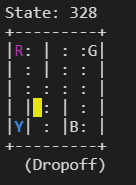

In [6]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Movement options:
0 = south,
1 = north,
2 = east,
3 = west,
4 = pickup,
5 = dropoff

# AI probeert het zonder trainen

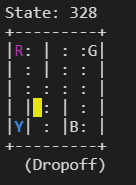

In [8]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

In [23]:
epochs = 0  # om bij te houden
penalties, reward = 0, 0
frames = [] # textuele weergave van elke stap
done = False

while not done:
    # Actie is een getal tussen 0-6 met welke kant er bewogen wordt/andere
    action = env.action_space.sample()

    # Step voert de actie uit en geeft terug de
    # state = weergave van de omgeving
    # reward = beloning op de gedane actie
    # done = geeft aan of er een passagier is opgepakt/afgezet
    # info = ms tijd die het duurde en andere dingen
    state, reward, done, info = env.step(action)

    # als de machine een fout maakt door iets te proberen wat niet kan wordt er een penalty toegevoegd
    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    epochs += 1
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 717
Penalties incurred: 241


## Eindframe na willekeurig gokken
timesteps geeft aan hoeveel pogingen het erover deed om er eindelijk te komen

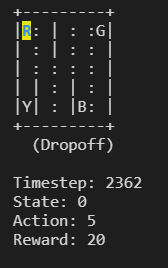

In [9]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

Aan de hoeveelheid timesteps te zien is het duidelijk dat het model er geen enkel idee van heeft wat er aan de hand is, dit komt omdat rewards en penalties niet gebruikt worden om het model te trainen en het alleen maar willekeurig aan het gokken is.
# Implementatie van Q-learning
In principe is deze simpele vorm van Q-learning het gebruiken van een geheugen voor het model, waarbij er onthouden wordt per staat van het veld wat de beste actie was die genomen kon worden.

In [35]:
import numpy as np
import random
from IPython.display import clear_output

# 2D list van 500 x 6 (6 acties met 500 mogelijke veld opties)
q_table = np.zeros([env.observation_space.n, env.action_space.n])
q_table.shape

(500, 6)

In [36]:
%%time
# Hyperparameters 
# learning rate
alpha = 0.1
# waarde van toekomstige rewards
gamma = 0.6
# geeft aan hoe groot de kans is dat het model afwijkt van de Q-waarde die al getrained is
epsilon = 0.1 

# waardes om te printen tijdens het trainen
all_epochs = []
all_penalties = []
temp_penalties = 0
steps = 0

# Probeert 50.000 verschillende veld staten
for i in range(1, 50001):
    # wordt elke keer getrained op random veld staat
    state = env.reset()
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    # blijft doorgaan tot het er uit is 
    while not done:
        # random keuze of de Q-score weer gekozen moet worden of niet (random.uniform geeft getal tussen 0 en 1)
        if random.uniform(0, 1) < epsilon:
            # Probeert nieuwe optie
             action = env.action_space.sample() 
        else:
            # Pakt al geleerde optie
            action = np.argmax(q_table[state])

        next_state, reward, done, info = env.step(action) 
        
        # pakt de oude waarde van de q-score
        old_value = q_table[state, action]
        # pakt beste actie voor de volgende staat
        next_max = np.max(q_table[next_state])

        # Pakt de oude waarde van de actie en vermenigvuldigd het met 1 - learning rate en doet de best 
        # mogelijke reward van de volgende stap er vermenigvuldigd met de learningrate bij
        # hiermee wordt er per actie per staat bepaald welke van de 6 mogelijke acties het beste is.
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        # zet de waarde voor de nieuwe q_waarde van de staat en actie in de q-table
        q_table[state, action] = new_value

        # houdt bij of er fouten gemaakt worden voor de trackers
        if reward == -10:
            penalties += 1
            temp_penalties += 1

        # vervant de oude staat met de nieuwe om verder te gaan met het model.
        state = next_state
        epochs += 1
        steps += 1
        
    # print output elke 1000 velden (te veel spam anders)
    if i % 1000 == 0:
        print(f"Episode: {i}, average steps taken past 1000: {steps / 1000}") 
        temp_penalties = 0
        steps = 0

print("Training finished.\n")

Episode: 1000, average steps taken past 1000: 118.771
Episode: 2000, average steps taken past 1000: 24.91
Episode: 3000, average steps taken past 1000: 18.263
Episode: 4000, average steps taken past 1000: 16.492
Episode: 5000, average steps taken past 1000: 15.5
Episode: 6000, average steps taken past 1000: 15.45
Episode: 7000, average steps taken past 1000: 15.146
Episode: 8000, average steps taken past 1000: 15.145
Episode: 9000, average steps taken past 1000: 14.942
Episode: 10000, average steps taken past 1000: 15.076
Episode: 11000, average steps taken past 1000: 14.73
Episode: 12000, average steps taken past 1000: 14.79
Episode: 13000, average steps taken past 1000: 14.807
Episode: 14000, average steps taken past 1000: 14.69
Episode: 15000, average steps taken past 1000: 14.818
Episode: 16000, average steps taken past 1000: 14.622
Episode: 17000, average steps taken past 1000: 14.844
Episode: 18000, average steps taken past 1000: 14.556
Episode: 19000, average steps taken past 10


# Q-learning tabel
De 0 waardes staan voor staten van het spel waar het model nog niet op getrained is, dit komt doordat het volledig willekeurig gedaan wordt. Hierom is het belangrijk om het model zo lang mogelijk te blijven trainen, waardoor het voor elke mogelijke staat een goede oplossing kan hebben. Het model stopt wel met fouten maken na ongeveer 10.000 keer proberen, alleen maakt het hier en daar nogsteeds fouten doordat het geen oplossing heeft gezien. Dat is te zien aan het feit dat de average steps niet op 12 zit (wat het laagste mogelijk is). Hierom moet het dus lang doortrainen voordat het perfect is

In [39]:
# index is de staat
q_table[0:10] 

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.4183556 ,  -2.36393392,  -2.41834577,  -2.36393767,
         -2.27325184, -11.36304075],
       [ -1.87013076,  -1.45025014,  -1.87013604,  -1.45038246,
         -0.7504    , -10.45003737],
       [ -2.36389015,  -2.27318187,  -2.36388306,  -2.27322081,
         -2.1220864 , -11.27011372],
       [ -2.49618998,  -2.49629594,  -2.49619   ,  -2.49632637,
         -8.72356947,  -9.84690354],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.49619114,  -2.49627518,  -2.49619113,  -2.4963261 ,
         -9.21959324,  -7.77653607],
       [ -2.48236334,  -2.48342937,  -2.48236289,  -2.48440655,
         -8.45270811,  -9.2606195 ],
       [ -2.27325184,  -2.32180531,  -2.34079048,  -2.33091547,
         -8.39447608,  -7.59596228],
       [ -2.47061344,  -2.47649982,  -2.47765543,  -2.47532209,
         -9.823697  ,  -8.4

In [33]:
"""Evaluate agent's performance after Q-learning"""
total_epochs, total_penalties = 0, 0
episodes = 250

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 250 episodes:
Average timesteps per episode: 12.98
Average penalties per episode: 0.0


# Trained model test
Runs the newly trained model through 1 scenario and saves all the frames

In [52]:
done = False
state = env.reset()
new_frames = []

while not done:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1

    # Adds the newly created frames to the new frames list with the step, state, reward and action taken
    new_frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

# Shows the new learning model and runs through its actions
Step by step image

Laat de stappen zien die de taxi neemt (gele stip, groen met passagier)

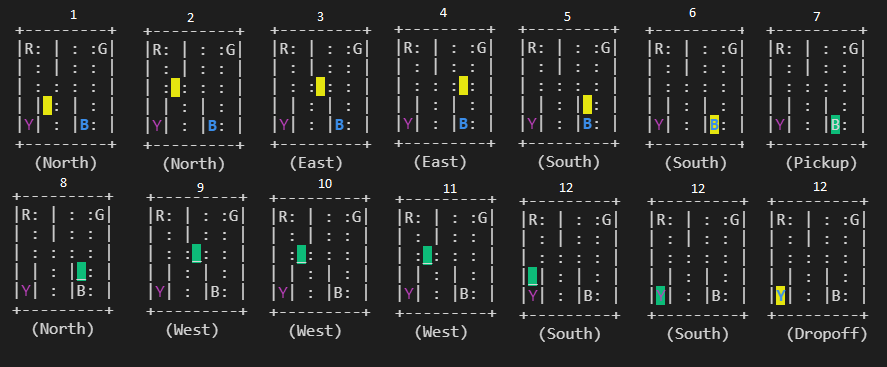

In [10]:
display(Image(filename='images/third_image.png'))

# Evaluatie

Om te beginnen is deze manier van reinforcement learning niet een deep learning model maar een gewoon algoritme met geheugen, hier wordt geen gebruik gemaakt van een vorm van neuraal netwerk maar alleen een tabel die bijhoudt wat de beste acties zijn. Hierom is het ook geen model dat kan reageren gebaseerd op de staat van het veld, maar een model dat gebaseerd op mogelijke scenario's weet wat per elke staat de goede actie is. Hierom als er en nieuwe actie is die moet gebeuren kan dit model niet gokken wat de beste oplossing is, maar maakt het model een willeurige actie zonder enig voorbehoud van de omgeving. Waarbij een deep learning reinforcement learning model kan schatten wat de beste oplossing is gebaseerd op hoe de rest van het veld eruit ziet.

Het Q-learning model is desondanks een goede manier om te leren hoe iets uitgewerkt moet worden, alleen is dit slecht bruikbaar als het gebruikt moet worden in een omgeving die telkens nieuwe staten krijgt. Hierbij zouden Deep Learning modellen wel beter zijn, alleen voor simpele vragen als dit is een Q-learning model zonder deep learning snel om te trainen en werkt het goed.

Hoe groter en ingewikkelder de velden worden des te slechter deze niet Deep Learning versie is, aangezien het voor elke mogelijke staat en actie moet bijhouden wat er moet gebeuren. Hierdoor gaat het steeds meer geheugen innemen per mogelijke veld staat en actie.

In principe is de enige manier om dit model nu echt te verbeteren om het vreselijk lang door te laten gaan totdat het model altijd de kortst mogelijke route neemt, alleen doordat het model moet trainen neemt het af en toe ook willekeurige besluiten. Hierdoor is het lastig te bepalen wanneer het model is uitgetraint, maar om te zorgen dat het in ieder geval altijd beter werkt zou er bij gehouden kunnen worden hoe vaak het model voor elke staat is geweest. Om hiermee te forceren dat het model ook de minst bezochte staten goed traint, waardoor elke staat van het veld de beste oplossing weet.

Bron: https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/